In [ ]:
!pip install statsmodels
!pip install arch
!pip install hurst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 11.7 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed


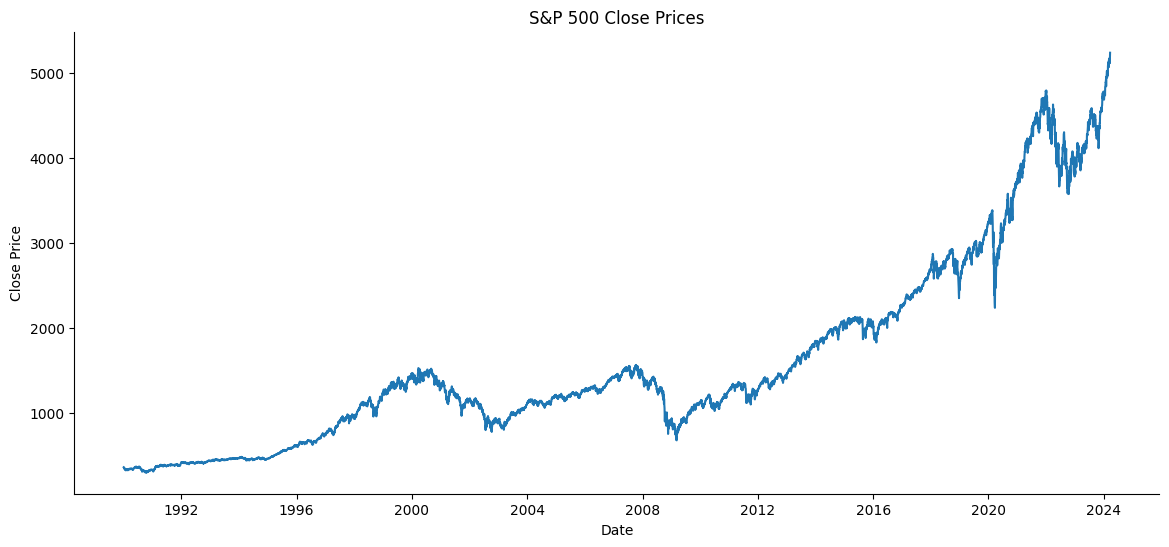

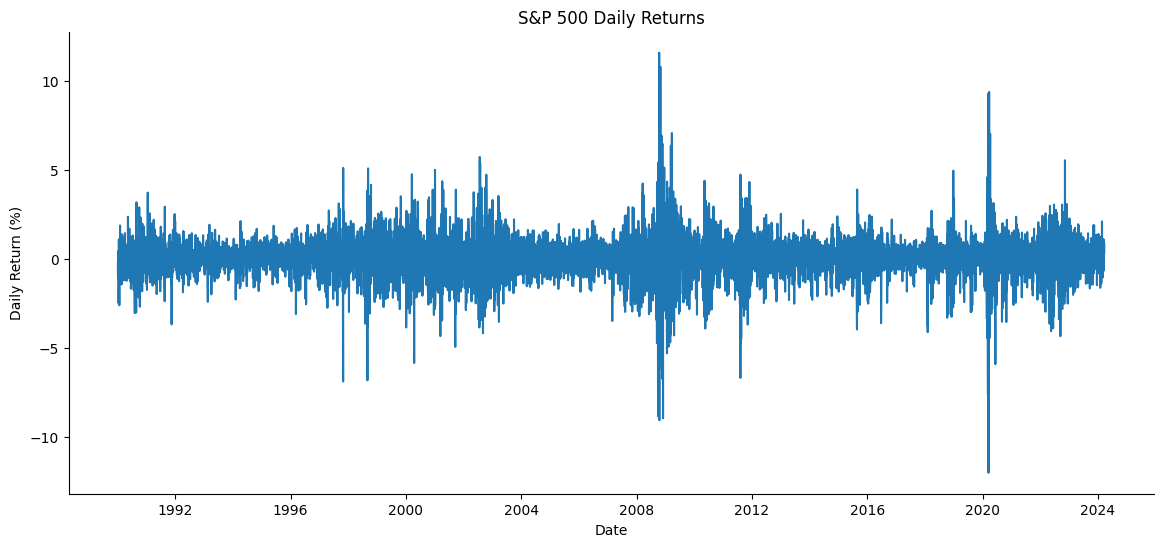

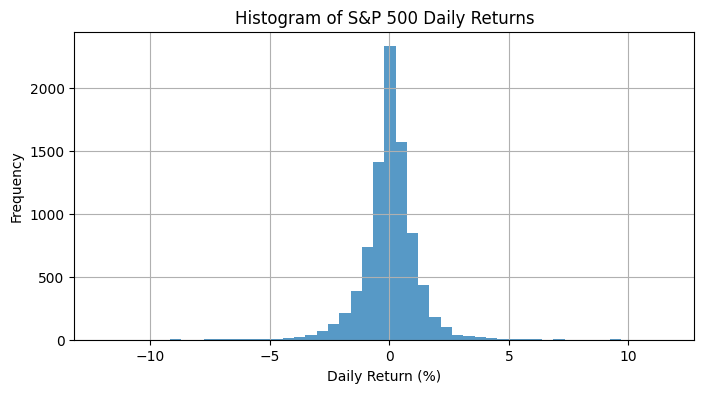

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# Load the S&P 500 index data from 1990-01-01 to present
sp500 = yf.download('^GSPC', start='1990-01-01')

# Plot Close Prices
plt.figure(figsize=(14, 6))
plt.plot(sp500['Close'])
plt.title('S&P 500 Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Calculate daily returns as a percentage change of the close prices
sp500['Return'] = sp500['Close'].pct_change() * 100

# Plot Returns
plt.figure(figsize=(14, 6))
plt.plot(sp500['Return'])
plt.title('S&P 500 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Plot the returns histogram
plt.figure(figsize=(8, 4))
sp500['Return'].hist(bins=50, alpha=0.75)
plt.title('Histogram of S&P 500 Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()


##Evaluating Market Efficiency
To assess the S&P 500's adherence to the Efficient Market Hypothesis (EMH), we employ several statistical tests on its returns:

1/ Augmented Dickey-Fuller Test: Tests for the presence of unit roots, indicating non-stationarity and potential predictability, which would challenge the EMH.

2/ Variance Ratio Test: Evaluates the random walk hypothesis by comparing variances over different periods. Deviations suggest trends or mean reversion, undermining the EMH.

3/ Ljung-Box Q-Test: Detects autocorrelations in the data. Significant findings imply past prices might predict future prices, opposing the EMH.

4/ Runs Test, or Wald–Wolfowitz Test: Checks data randomness. An unusual number of runs indicates patterns or trends, hinting at inefficiencies.

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.unitroot import VarianceRatio
from statsmodels.sandbox.stats.runs import runstest_1samp

def test_market_efficiency(series, lags_vr=10, lags_lb=10):
    """
    Conducts various tests to assess the market efficiency of a given financial time series.

    Parameters:
    - series: pandas Series of returns or prices.
    - lags_vr: Number of lags for the Variance Ratio test.
    - lags_lb: Number of lags for the Ljung-Box Q-test.

    Returns:
    - results: A dictionary containing the results of the tests.
    """
    series = series.dropna()  # Ensure no NaN values
    results = {}

    # Augmented Dickey-Fuller test
    adf_result = adfuller(series)
    results['ADF Statistic'] = adf_result[0]
    results['ADF p-value'] = adf_result[1]

    # Variance Ratio Test
    vr = VarianceRatio(series, lags=lags_vr)
    results['Variance Ratio Test Statistic'] = vr.stat
    results['Variance Ratio Test p-value'] = vr.pvalue

    # Ljung-Box Q-test for autocorrelation
    lb_result = acorr_ljungbox(series, lags=[lags_lb], return_df=True)
    results['Ljung-Box Q-Test'] = lb_result.iloc[0]['lb_pvalue']

    # Runs Test for randomness
    binary_sequence = np.where(series.diff().dropna() > 0, 1, 0)
    runs_stat, runs_p_value = runstest_1samp(binary_sequence, correction=True)
    results['Runs Test Statistic'] = runs_stat
    results['Runs Test P-Value'] = runs_p_value

    return results

# Example usage with a time series of S&P 500 returns
sp500_returns = sp500['Return'].dropna()
efficiency_results = test_market_efficiency(sp500_returns)
for test, result in efficiency_results.items():
    print(f"{test}: {result}")


ADF Statistic: -17.2829107971031
ADF p-value: 5.767134091522255e-30
Variance Ratio Test Statistic: -9.087682570802741
Variance Ratio Test p-value: 0.0
Ljung-Box Q-Test: 2.864814235056571e-16
Runs Test Statistic: 31.435119489596833
Runs Test P-Value: 6.705110615308334e-217


ADF Test: The negative statistic and extremely low p-value indicate the series is stationary, suggesting mean-reversion or autocorrelation.
Variance Ratio Test: A significant negative statistic and zero p-value reject the random walk hypothesis, implying predictability.
Ljung-Box Q-Test: A very low p-value suggests significant autocorrelation, challenging randomness.
Runs Test: The extreme statistic and p-value near zero indicate non-randomness, suggesting the presence of trends.

In [ ]:
# Example usage with a time series of S&P 500 close prices
sp500_close_prices = sp500['Close'].dropna()
efficiency_results_close = test_market_efficiency(sp500_close_prices)
for test, result in efficiency_results_close.items():
    print(f"{test}: {result}")


ADF Statistic: 2.3490404234843334
ADF p-value: 0.9989842729589694
Variance Ratio Test Statistic: -1.4114604707843192
Variance Ratio Test p-value: 0.15810888333358442
Ljung-Box Q-Test: 0.0
Runs Test Statistic: 2.9910582392798917
Runs Test P-Value: 0.0027801246577656242


ADF Test: High p-value suggests the series is non-stationary, indicating potential trends or cycles.
Variance Ratio Test: Not significantly different from 0, suggesting a random walk might hold.
Ljung-Box Q-Test: Near-zero p-value indicates autocorrelation, contradicting pure randomness.
Runs Test: Low p-value suggests non-randomness, indicating trends or patterns.


The S&P 500 close price series isn't steady over time, which we see from the Augmented Dickey-Fuller test. The test's results show the series likely has trends or patterns. To handle this, we can remove the trend (detrend the series) to make it steady, meaning its characteristics don't change over time. We also use seasonal decomposition to break down the series into trend, seasonality, and random components. This helps us see what's causing changes in the series, making it easier to analyze and potentially predict.

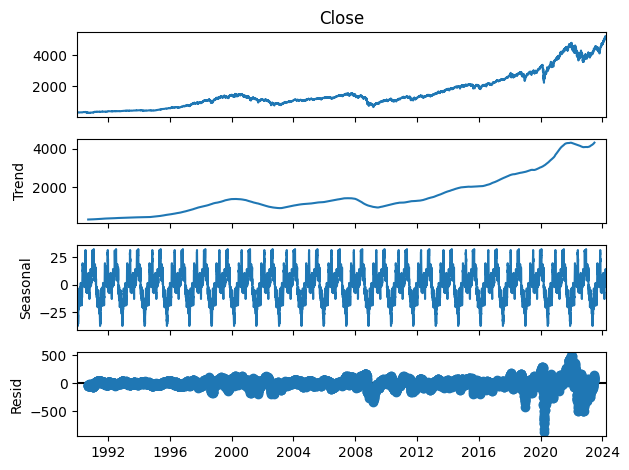

In [ ]:
## Detecting Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(sp500['Close'], model='additive', period=365)

# Plot the decomposed components
decomposition.plot()
plt.show()

In [ ]:
# Assuming 'sp500' is already defined and contains the S&P 500 data
# Apply first-order differencing to the Close prices to achieve stationarity
close_diff = sp500['Close'].diff().dropna()

# Perform the efficiency tests on the differenced data
efficiency_results_diff = test_market_efficiency(close_diff)
efficiency_results_diff


{'ADF Statistic': -16.025389748197593,
 'ADF p-value': 6.139528595909737e-29,
 'Variance Ratio Test Statistic': -5.897033581236326,
 'Variance Ratio Test p-value': 3.7009455500225386e-09,
 'Ljung-Box Q-Test': 7.072135314851508e-62,
 'Runs Test Statistic': 31.45084501907262,
 'Runs Test P-Value': 4.0874174814373e-217}

#The Hurst Exponent
a statistical measure used to determine the long-term memory of time series data, indicating whether a series is trending, mean-reverting, or a random walk. Named after Harold Edwin Hurst, it helps in understanding the predictability and characteristics of financial markets. A Hurst Exponent close to 0.5 suggests a random walk, values greater than 0.5 indicate a trending behavior, and values less than 0.5 suggest mean-reversion. This concept is essential for financial analysis, providing insights into market behavior and aiding in the development of trading strategies.

Hurst Exponent: 0.790713624876209


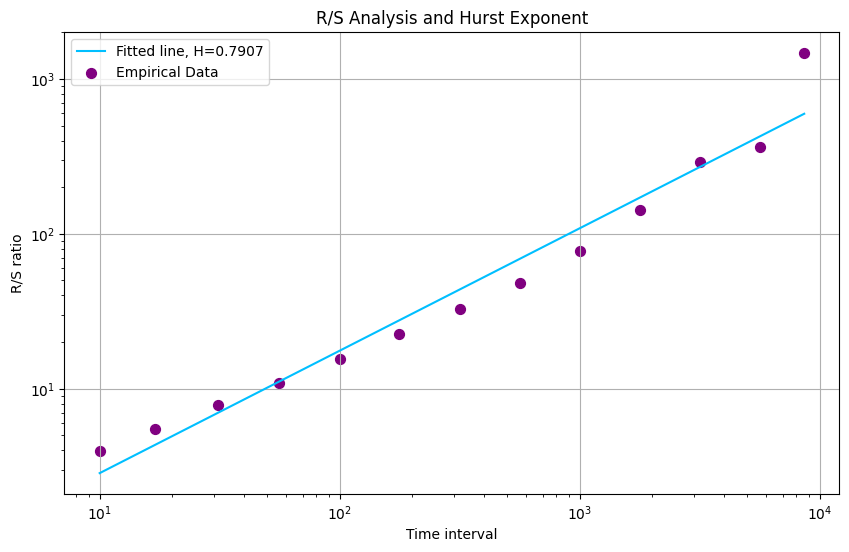

In [ ]:
import numpy as np
import pandas as pd
from hurst import compute_Hc
import matplotlib.pyplot as plt

def compute_and_plot_hurst(series, kind='price', simplified=True, plot=True):
    """
    Computes the Hurst exponent for a given time series and optionally plots the R/S analysis.

    Parameters:
    - series: Pandas Series, the time series data to analyze.
    - kind: String, the type of series ('price' for cumulative product or 'change' for simple difference).
    - simplified: Boolean, whether to use the simplified approach for Hurst exponent calculation.
    - plot: Boolean, whether to plot the R/S analysis.

    Returns:
    - H: The Hurst exponent.
    """
    # Compute the Hurst exponent
    H, c, data = compute_Hc(series, kind=kind, simplified=simplified)
    print(f"Hurst Exponent: {H}")

    # Plotting the R/S analysis if required
    if plot:
        plt.figure(figsize=(10, 6))
        plt.loglog(data[0], c * data[0] ** H, color="deepskyblue", label=f'Fitted line, H={H:.4f}')
        plt.scatter(data[0], data[1], color="purple", s=50, label='Empirical Data')
        plt.xlabel('Time interval')
        plt.ylabel('R/S ratio')
        plt.grid(True)
        plt.legend()
        plt.title('R/S Analysis and Hurst Exponent')
        plt.show()

    return H

# Example usage
# Assuming 'sp500' is your DataFrame and 'Close' is the column with the closing prices
close_prices = sp500['Close']
hurst_exponent = compute_and_plot_hurst(close_prices)


Hurst Exponent: 0.6149833775927609


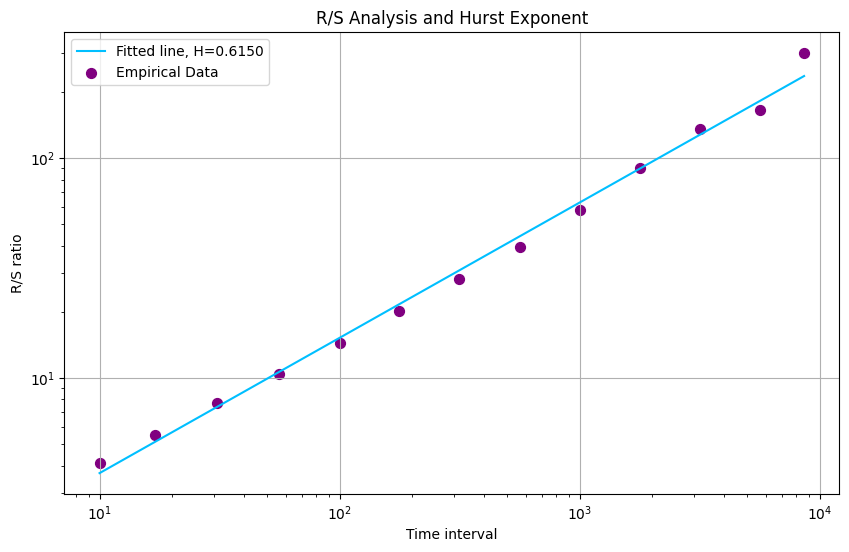

In [ ]:
# Assuming 'sp500' is your DataFrame and 'Return' is the column with the Returns
returns = sp500['Return'].dropna()
hurst_exponent = compute_and_plot_hurst(returns, kind='change')

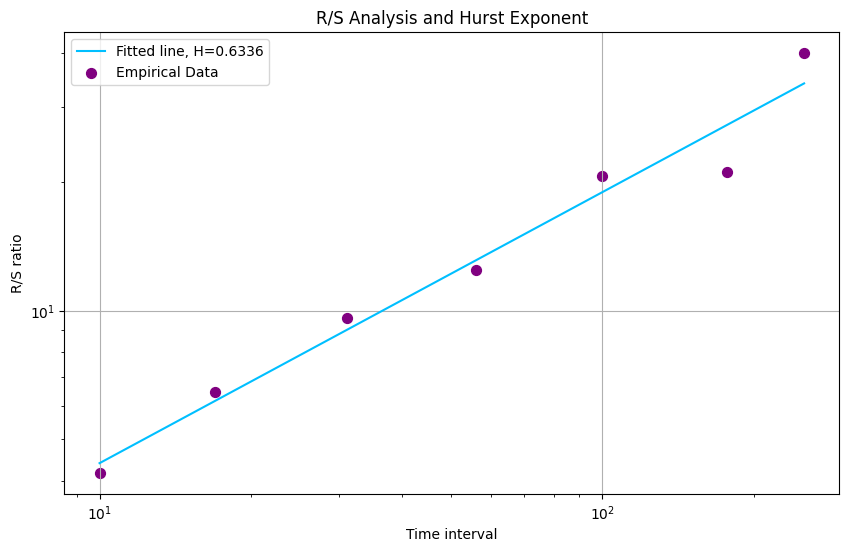

Hurst Exponent: 0.9525130539286941


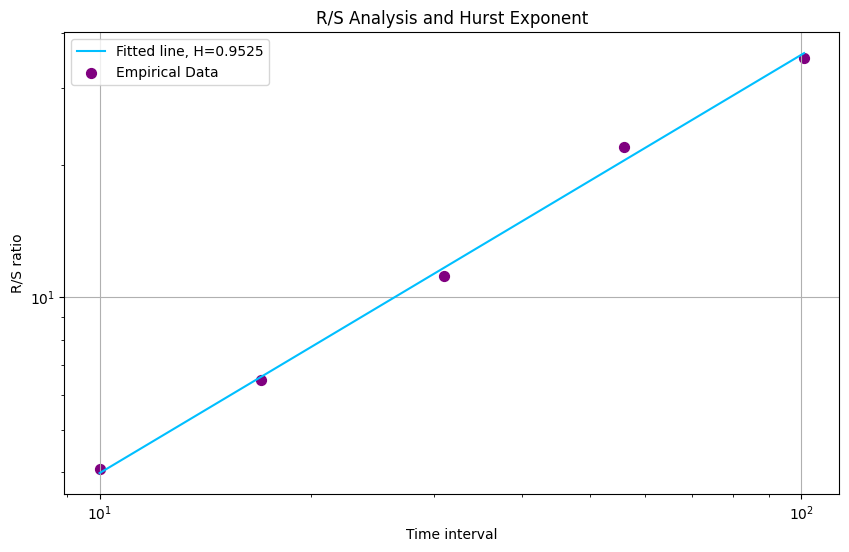

In [ ]:
# Assuming 'sp500_returns' is a pandas Series of the S&P 500 daily returns
# For the last 252 trading days (approx one year)
last_year_returns = sp500_returns[-252:]
h_exp_lastyear = compute_and_plot_hurst(last_year_returns, kind='change')

# For the last 21 weeks
# Calculate the start date for the last 8 weeks
end_date = sp500.index.max()
start_date = end_date - pd.DateOffset(weeks=21)

# Filter the returns for the last 8 weeks
returns_21weeks = sp500.loc[start_date:end_date, 'Return']
h_exp_last21 = compute_and_plot_hurst(returns_21weeks, kind='change')



Hurst Exponent: 0.6818977357872723


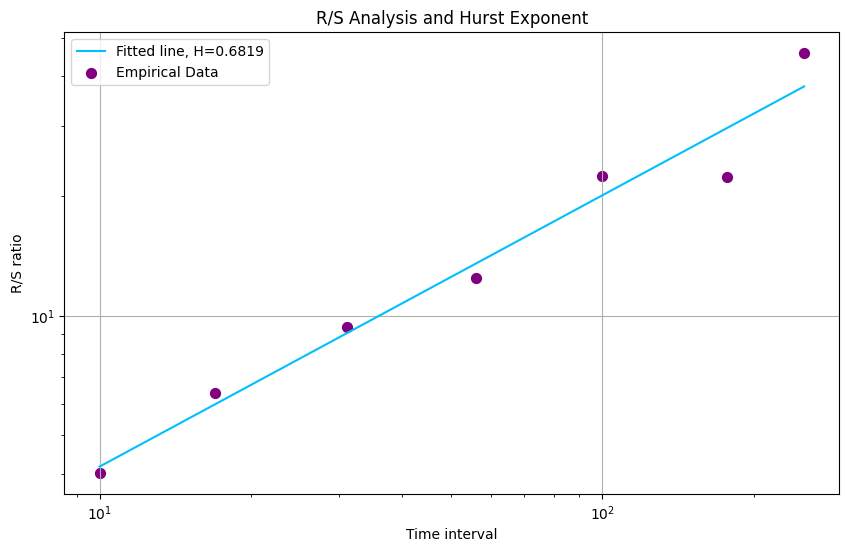

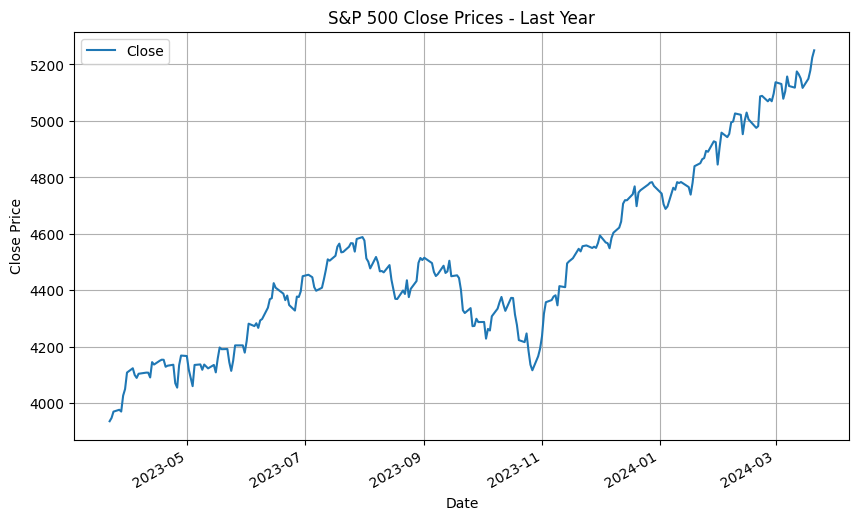

Hurst Exponent: 0.8785144290503245


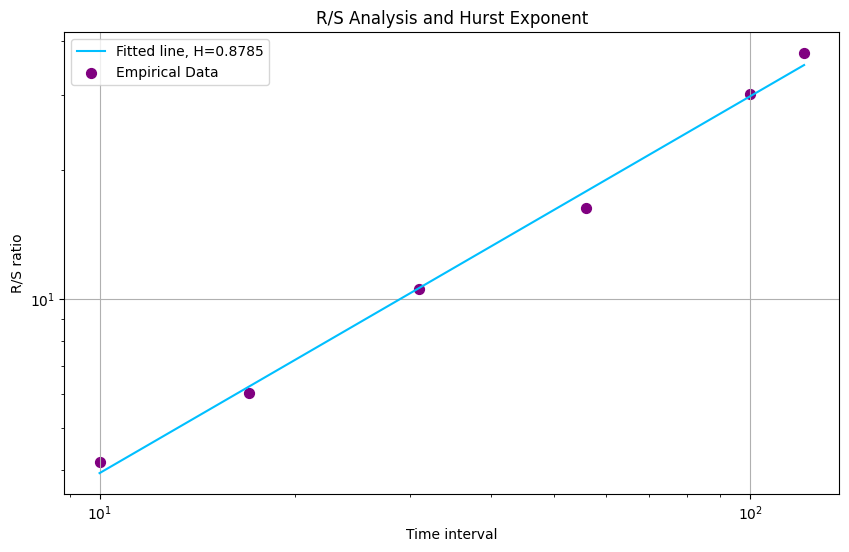

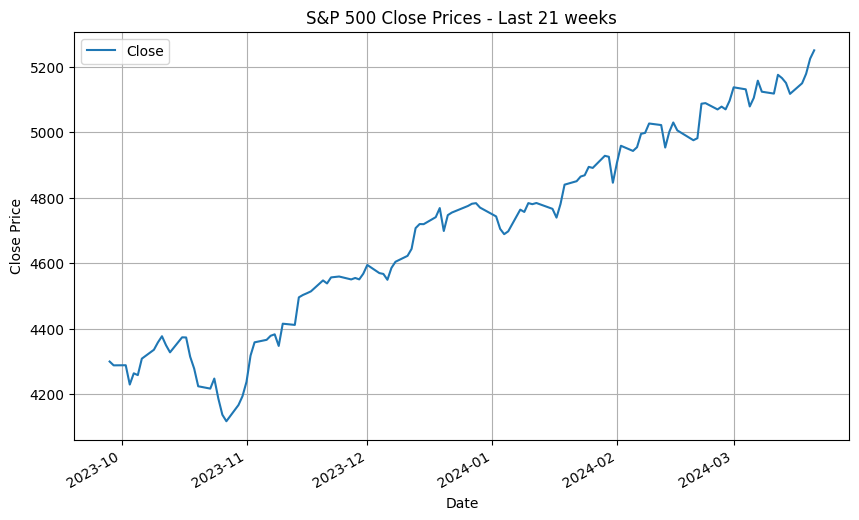

In [ ]:
# Assuming 'sp500' is your DataFrame containing the S&P 500 index data
# For the last 252 trading days (approx one year) using close prices
last_year_close = sp500['Close'][-252:]
h_exp_last_year_close = compute_and_plot_hurst(last_year_close, kind='price')

last_year_close.plot(figsize=(10, 6), title='S&P 500 Close Prices - Last Year', xlabel='Date', ylabel='Close Price', legend=True)
plt.grid(True)  # Adds a grid for better readability
plt.show()


# For the last 21 weeks using close prices
# Calculate the start date for the last 21 weeks (not 8 weeks as mentioned in your comment)
end_date_close = sp500.index.max()
start_date_close = end_date_close - pd.DateOffset(weeks=25)

# Filter the close prices for the last 21 weeks
close_prices_21weeks = sp500.loc[start_date_close:end_date_close, 'Close']
h_exp_last_21weeks_close = compute_and_plot_hurst(close_prices_21weeks, kind='price')

# plot close price in the same period
close_prices_21weeks.plot(figsize=(10, 6), title='S&P 500 Close Prices - Last 21 weeks', xlabel='Date', ylabel='Close Price', legend=True)
plt.grid(True)  # Adds a grid for better readability
plt.show()



## Segment SP500, to test different H-exponents in different periods
segments the S&P 500 close prices into yearly frames, computes the Hurst exponent for each segment, classifies them based on the median Hurst exponent, and visualizes the results. It helps identify periods with different memory characteristics within the market, potentially indicating varying market efficiency or predictability.

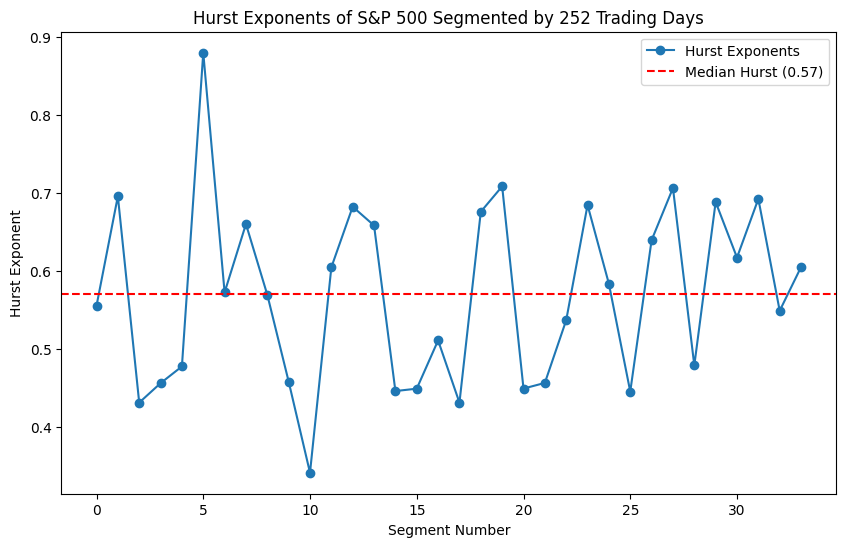

Number of lower Hurst segments: 17
Number of higher Hurst segments: 17


In [ ]:
import numpy as np
import pandas as pd
from hurst import compute_Hc
import matplotlib.pyplot as plt

# Load the S&P 500 data
close_prices = sp500['Close']

# Define the segment size (one trading year)
segment_size = 252

# Calculate the number of segments
num_segments = len(close_prices) // segment_size

# Create segments
segments = [close_prices[i*segment_size:(i+1)*segment_size] for i in range(num_segments)]

# Compute Hurst exponents for each segment
hurst_exponents = [compute_Hc(segment, kind='price', simplified=True)[0] for segment in segments]

# Calculate the median Hurst exponent
median_hurst = np.median(hurst_exponents)
#h_upper_level = 0.6
#h_lower_level = 0.45
h_upper_level = median_hurst
h_lower_level = median_hurst

# Classify segments based on the Hurst exponent
lower_hurst_segments = [segments[i] for i, H in enumerate(hurst_exponents) if H < h_lower_level]
higher_hurst_segments = [segments[i] for i, H in enumerate(hurst_exponents) if H >= h_upper_level]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hurst_exponents, marker='o', linestyle='-', label='Hurst Exponents')
plt.axhline(y=median_hurst, color='r', linestyle='--', label=f'Median Hurst ({median_hurst:.2f})')
plt.title('Hurst Exponents of S&P 500 Segmented by 252 Trading Days')
plt.xlabel('Segment Number')
plt.ylabel('Hurst Exponent')
plt.legend()
plt.show()

# Output the number of segments in each group
print(f"Number of lower Hurst segments: {len(lower_hurst_segments)}")
print(f"Number of higher Hurst segments: {len(higher_hurst_segments)}")


In [ ]:
# Convert each segment into a DataFrame with a 'Close' column
segments_df = [pd.DataFrame(segment, columns=['Close']) for segment in segments]

# Hurst vs Market Volatility
Plotting these average volatilities allows us to visually compare the behavior of segments with different Hurst exponent values. Specifically, it can show whether segments with a higher Hurst exponent (indicating a trending behavior) tend to have different volatility patterns compared to those with a lower Hurst exponent (indicating mean-reverting behavior).

This analysis can provide insights into the nature of financial markets, particularly how the inherent properties of price movements (as captured by the Hurst exponent) are related to the risk (volatility) experienced over time. Traders and analysts can use such insights to tailor their strategies according to the expected market behavior, choosing different approaches for managing investments in lower versus higher Hurst segments.

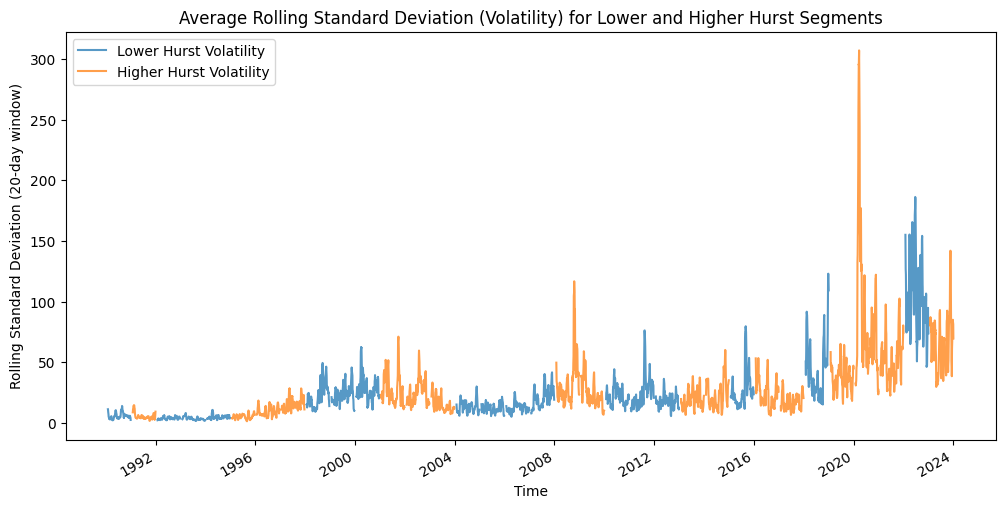

In [ ]:
# Calculate rolling standard deviation for each segment in both groups
lower_hurst_volatility = [segment.rolling(window=20).std() for segment in lower_hurst_segments]
higher_hurst_volatility = [segment.rolling(window=20).std() for segment in higher_hurst_segments]

# Calculate the average rolling standard deviation for each group
avg_lower_hurst_volatility = pd.concat(lower_hurst_volatility, axis=1).mean(axis=1)
avg_higher_hurst_volatility = pd.concat(higher_hurst_volatility, axis=1).mean(axis=1)

# Plotting
plt.figure(figsize=(12, 6))
avg_lower_hurst_volatility.plot(label='Lower Hurst Volatility', alpha=0.75)
avg_higher_hurst_volatility.plot(label='Higher Hurst Volatility', alpha=0.75)
plt.title('Average Rolling Standard Deviation (Volatility) for Lower and Higher Hurst Segments')
plt.xlabel('Time')
plt.ylabel('Rolling Standard Deviation (20-day window)')
plt.legend()
plt.show()


The results show that segments with a higher Hurst exponent exhibit greater volatility compared to those with a lower Hurst exponent. This means that markets or segments where trends are more pronounced (higher Hurst) tend to have larger and more frequent price changes. On the other hand, segments that are more likely to revert to a mean (lower Hurst) demonstrate smaller and less frequent price changes, indicating less volatility.

This insight is valuable for investors and traders. It suggests that investing in areas with higher Hurst exponents might involve higher risks due to increased volatility. Hence, careful risk management strategies are crucial. In contrast, markets with lower Hurst exponents might offer more stable and predictable investment opportunities, albeit potentially with lower returns.

# Trend-following Trading Strategy
Buy Signal: Generated when the short-term moving average crosses above the long-term moving average. This indicates that the asset's price is gaining momentum compared to its recent average, suggesting an upward trend. Traders might consider this a good time to enter a long position.

Sell Signal: Occurs when the short-term moving average crosses below the long-term moving average. This suggests that the asset's price is losing momentum or starting to trend downwards compared to its average over a longer period. It might be considered an indicator to close a long position or enter a short position.

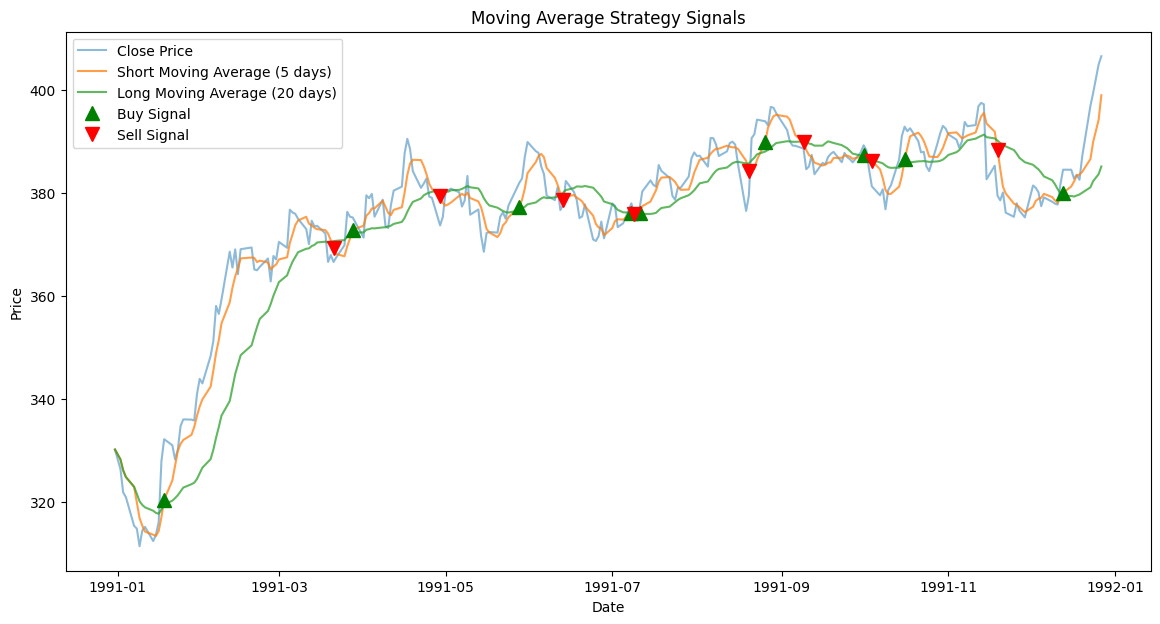

In [ ]:
import pandas as pd
import numpy as np

def apply_moving_average_strategy(series, short_window, long_window):
    """
    Applies a moving average crossover strategy to a time series.

    Parameters:
    - series: pandas Series, the time series data of prices.
    - short_window: int, the window length for the short moving average.
    - long_window: int, the window length for the long moving average.

    Returns:
    - signals: pandas DataFrame, contains the signals and moving averages.
    """
    signals = pd.DataFrame(index=series.index)
    signals['price'] = series.copy()
    signals['short_mavg'] = series.rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = series.rolling(window=long_window, min_periods=1, center=False).mean()
    signals['signal'] = 0
    #signals.loc[short_window:, 'signal'] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1, 0)
    signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(signals.iloc[short_window:]['short_mavg'] > signals.iloc[short_window:]['long_mavg'], 1, 0)
    signals['positions'] = signals['signal'].diff()

    return signals

# Example usage with a higher Hurst segment (assuming it's a pandas Series)
short_window = 5
long_window = 20
higher_hurst_signals = apply_moving_average_strategy(higher_hurst_segments[0], short_window, long_window)

# Plotting the prices and moving averages
plt.figure(figsize=(14, 7))
plt.plot(higher_hurst_signals['price'], label='Close Price', alpha=0.5)
plt.plot(higher_hurst_signals['short_mavg'], label=f'Short Moving Average ({short_window} days)', alpha=0.75)
plt.plot(higher_hurst_signals['long_mavg'], label=f'Long Moving Average ({long_window} days)', alpha=0.75)

# Plotting buy signals
plt.plot(higher_hurst_signals[higher_hurst_signals['positions'] == 1].index,
         higher_hurst_signals['short_mavg'][higher_hurst_signals['positions'] == 1],
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plotting sell signals
plt.plot(higher_hurst_signals[higher_hurst_signals['positions'] == -1].index,
         higher_hurst_signals['short_mavg'][higher_hurst_signals['positions'] == -1],
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('Moving Average Strategy Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<ipython-input-25-24b328635465>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Portfolio Value'].iloc[i] = capital + (position * signals['price'].iloc[i])
<ipython-input-25-24b328635465>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['Portfolio Value'].iloc[i] = capital + (position * signals['price'].iloc[i])


Final Capital after trading (Higher Hurst Segment): $11,513.39
Final Capital after trading (Lower Hurst Segment): $9,873.10


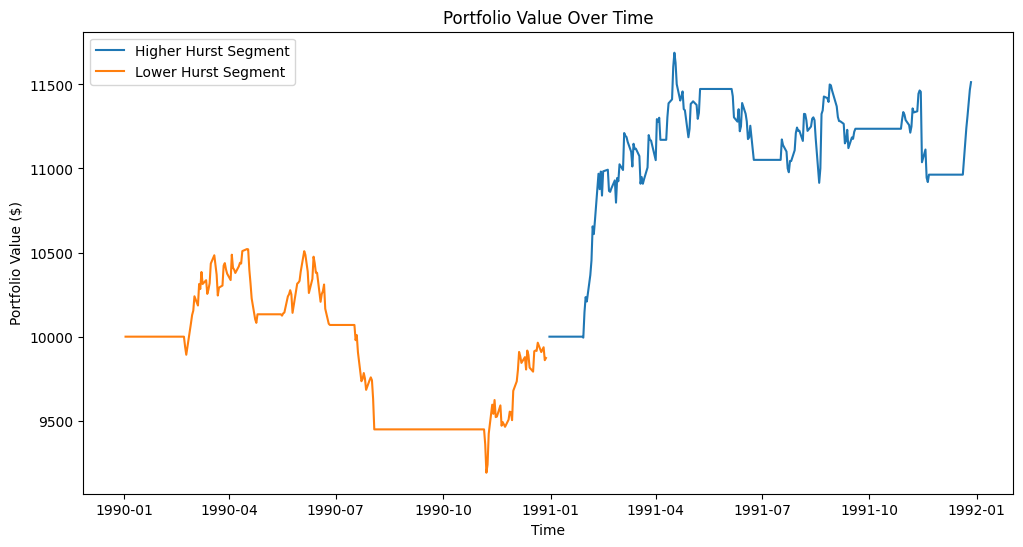

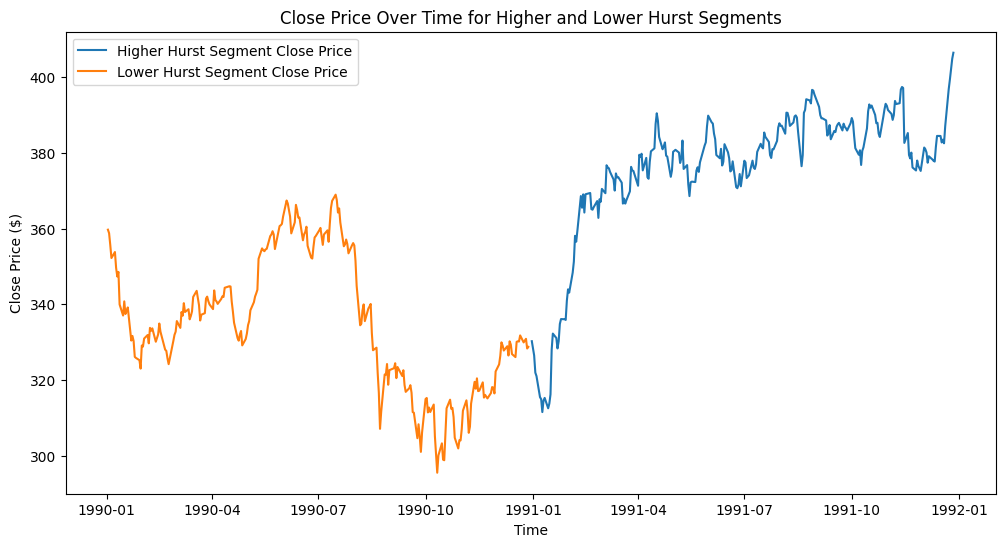

In [ ]:
def simulate_trading(signals, initial_capital=10000):
    """
    Simulates trading based on moving average crossover signals.

    Parameters:
    - signals: pandas DataFrame, contains the price, moving averages, and signals.
    - initial_capital: float, initial capital for trading.

    Returns:
    - final_capital: final capital after executing the trades.
    - signals: DataFrame including the portfolio value over time.
    """
    position = 0  # Current position
    capital = initial_capital
    signals['Portfolio Value'] = capital

    for i in range(1, len(signals)):
        if signals['positions'].iloc[i] == 1:  # Buy signal
            if position == 0:  # Only buy if currently not holding the stock
                position = capital / signals['price'].iloc[i]  # Buy as much as possible
                capital = 0
        elif signals['positions'].iloc[i] == -1:  # Sell signal
            if position > 0:  # Only sell if currently holding the stock
                capital = position * signals['price'].iloc[i]  # Sell all
                position = 0

        signals['Portfolio Value'].iloc[i] = capital + (position * signals['price'].iloc[i])

    final_capital = capital + (position * signals['price'].iloc[-1])  # Final capital
    return final_capital, signals

# Apply the trading simulation to one higher Hurst and one lower Hurst segment
higher_hurst_ma_signals = apply_moving_average_strategy(higher_hurst_segments[0], 15, 25)
lower_hurst_ma_signals = apply_moving_average_strategy(lower_hurst_segments[0], 15, 25)

final_capital_higher, higher_hurst_with_portfolio = simulate_trading(higher_hurst_ma_signals)
final_capital_lower, lower_hurst_with_portfolio = simulate_trading(lower_hurst_ma_signals)

print(f"Final Capital after trading (Higher Hurst Segment): ${final_capital_higher:,.2f}")
print(f"Final Capital after trading (Lower Hurst Segment): ${final_capital_lower:,.2f}")

plt.figure(figsize=(12, 6))
plt.plot(higher_hurst_with_portfolio.index, higher_hurst_with_portfolio['Portfolio Value'], label='Higher Hurst Segment')
plt.plot(lower_hurst_with_portfolio.index, lower_hurst_with_portfolio['Portfolio Value'], label='Lower Hurst Segment')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(higher_hurst_with_portfolio.index, higher_hurst_segments[0], label='Higher Hurst Segment Close Price')
plt.plot(lower_hurst_with_portfolio.index, lower_hurst_segments[0], label='Lower Hurst Segment Close Price')
plt.title('Close Price Over Time for Higher and Lower Hurst Segments')
plt.xlabel('Time')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()



The trading strategy based on moving averages yields different outcomes for segments classified by their Hurst exponent values. For the higher Hurst segment, the final capital stands at \$11,513.39.

This indicates a profit from the initial capital of \$10,000. This suggests that the trend-following strategy effectively capitalized on the persistence or trend-following behavior typically associated with higher Hurst exponents. In contrast, the final capital for the lower Hurst segment is $9,873.10, which is less than the initial capital, indicating a loss. Lower Hurst segments, which tend to exhibit mean-reverting behavior, may not align as well with trend-following strategies like the moving average crossover, leading to less favorable outcomes.

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

Final Capital after continuous MA trading (Higher Hurst): $403,471.68


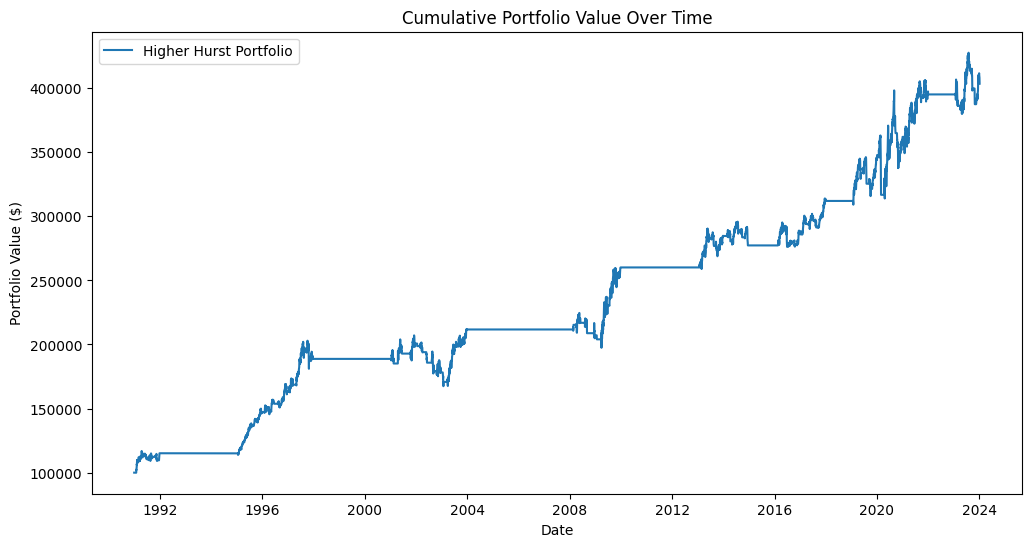

In [ ]:
def simulate_continuous_ma_trading(segments, initial_capital=10000, short_window=15, long_window=25):
    """
    Simulates continuous trading using a moving average strategy over multiple segments with date index.

    Parameters:
    - segments: list of pandas Series, each representing a price series for a segment with datetime index.
    - initial_capital: float, initial capital for the first segment's trading.
    - short_window: int, window length for the short moving average.
    - long_window: int, window length for the long moving average.

    Returns:
    - final_capital: final capital after trading through all segments.
    - cumulative_portfolio_df: pandas DataFrame, the cumulative portfolio values with date index across all segments.
    """
    capital = initial_capital
    cumulative_portfolio_df = pd.DataFrame()

    for segment in segments:
        signals = apply_moving_average_strategy(segment, short_window, long_window)
        final_capital, portfolio = simulate_trading(signals, capital)
        capital = final_capital  # Update capital for the next segment

        # Concatenate portfolio values for cumulative plotting
        if cumulative_portfolio_df.empty:
            cumulative_portfolio_df = portfolio[['Portfolio Value']].copy()
        else:
            cumulative_portfolio_df = pd.concat([cumulative_portfolio_df, portfolio[['Portfolio Value']]])

    return final_capital, cumulative_portfolio_df

# Assuming higher_hurst_segments is a list of pandas Series of close prices for each higher Hurst segment
final_capital_higher, cumulative_portfolio_higher = simulate_continuous_ma_trading(higher_hurst_segments, initial_capital=100000)

print(f"Final Capital after continuous MA trading (Higher Hurst): ${final_capital_higher:,.2f}")

# Plotting cumulative portfolio values
plt.figure(figsize=(12, 6))
plt.plot(cumulative_portfolio_higher.index, cumulative_portfolio_higher['Portfolio Value'], label='Higher Hurst Portfolio')
plt.title('Cumulative Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()


Final Capital after continuous MA trading (Lower Hurst): $94,780.87


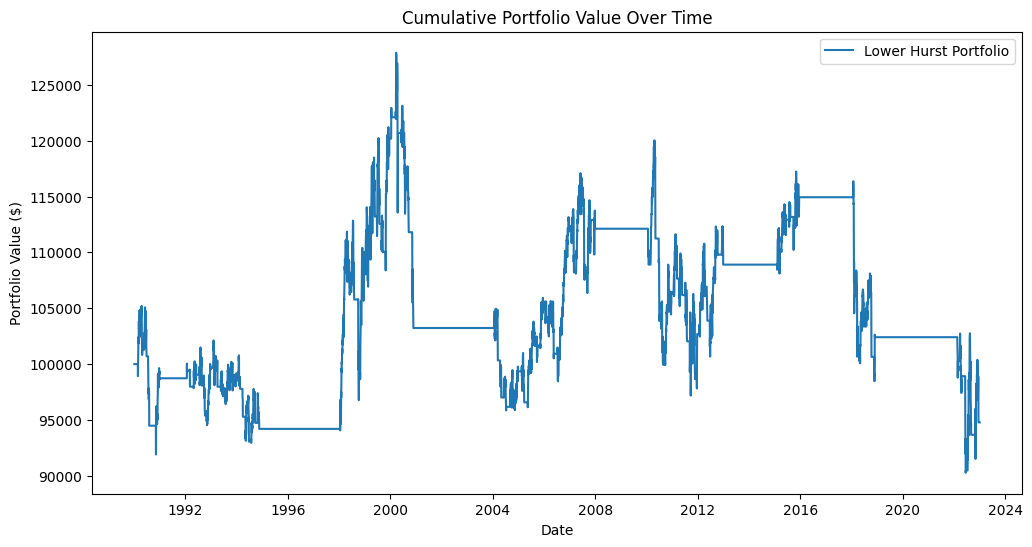

In [ ]:
# test for lower hurst segment
final_capital_lower, cumulative_portfolio_lower = simulate_continuous_ma_trading(lower_hurst_segments, initial_capital=100000)

print(f"Final Capital after continuous MA trading (Lower Hurst): ${final_capital_lower:,.2f}")

# Plotting cumulative portfolio values
plt.figure(figsize=(12, 6))
plt.plot(cumulative_portfolio_lower.index, cumulative_portfolio_lower['Portfolio Value'], label='Lower Hurst Portfolio')
plt.title('Cumulative Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

## MACD trading strategy
Buy Signal: A buy signal is generated when the MACD Line crosses above the Signal Line. This crossover indicates that the short-term momentum is rising faster than the long-term momentum, suggesting that the asset's price might be entering an uptrend, making it a good time to buy.

Sell Signal: A sell signal occurs when the MACD Line crosses below the Signal Line. This indicates that the short-term momentum is slowing compared to the long-term momentum, suggesting that the asset's price might be starting a downtrend, potentially making it a good time to sell.


In [ ]:
import pandas as pd
import numpy as np

def apply_macd_strategy(df, close_col='Close'):
    """
    Applies a MACD trading strategy to a DataFrame and returns signals.

    Parameters:
    - df: DataFrame containing the stock data.
    - close_col: String name of the column containing the close prices.

    Returns:
    - DataFrame with additional columns for 'EMA12', 'EMA26', 'MACD', 'Signal',
      'Buy_Signal', and 'Sell_Signal'.
    """

    # Ensure df is a copy to avoid modifying original data
    df = df.copy()

    # Calculate MACD components
    df['EMA12'] = df[close_col].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df[close_col].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Generate signals
    df['Buy_Signal'] = np.where((df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1)), 1, 0)
    df['Sell_Signal'] = np.where((df['MACD'] < df['Signal']) & (df['MACD'].shift(1) >= df['Signal'].shift(1)), 1, 0)

    return df



def segment_to_dataframe(segment):
    """
    Converts a pandas Series segment into a DataFrame with a 'Close' column.

    Parameters:
    - segment: pandas Series, where the index is dates and values are prices.

    Returns:
    - DataFrame with a 'Close' column containing the prices.
    """
    df = pd.DataFrame(segment)
    df.columns = ['Close']  # Rename the single column to 'Close'
    return df

# Assuming higher_hurst_segments and lower_hurst_segments are lists of pandas Series
higher_hurst_df_0 = segment_to_dataframe(higher_hurst_segments[0])
lower_hurst_df_0 = segment_to_dataframe(lower_hurst_segments[0])

# Now you can apply your MACD strategy function to these DataFrames
higher_hurst_df = apply_macd_strategy(higher_hurst_df_0)
lower_hurst_df = apply_macd_strategy(lower_hurst_df_0)


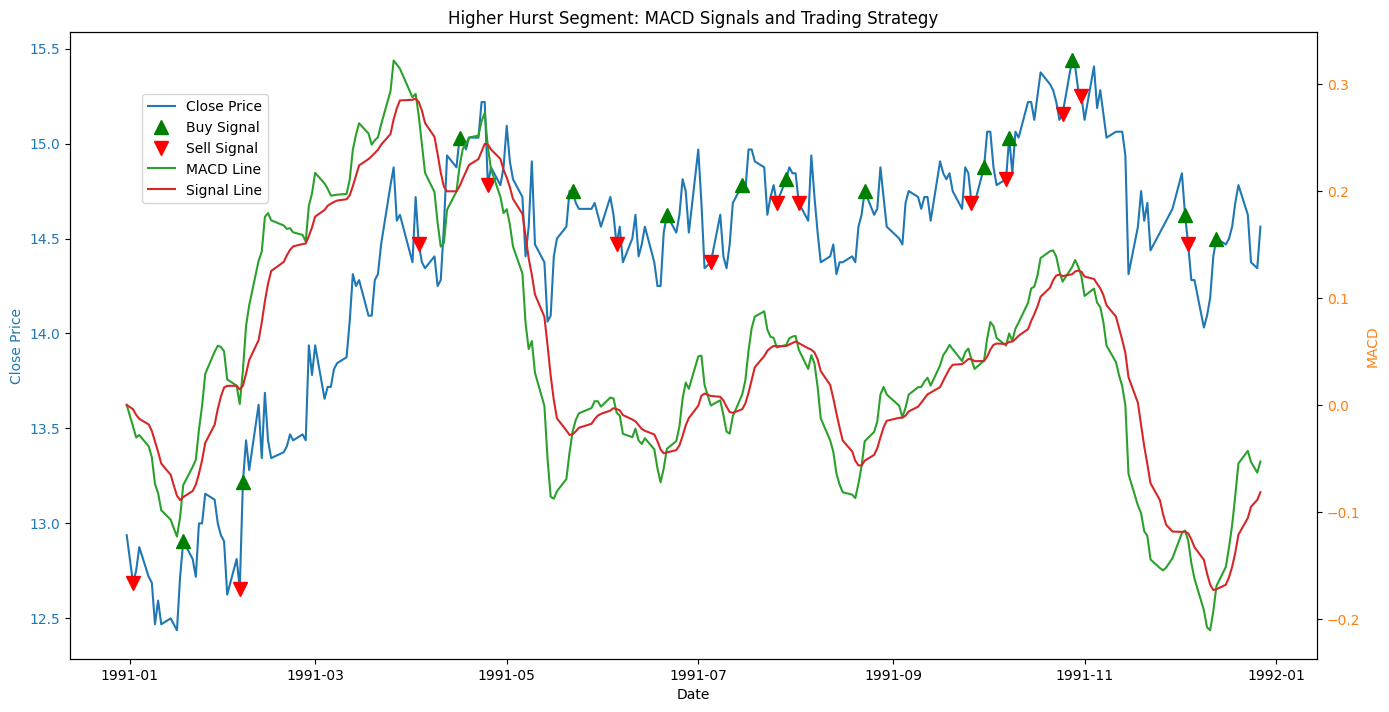

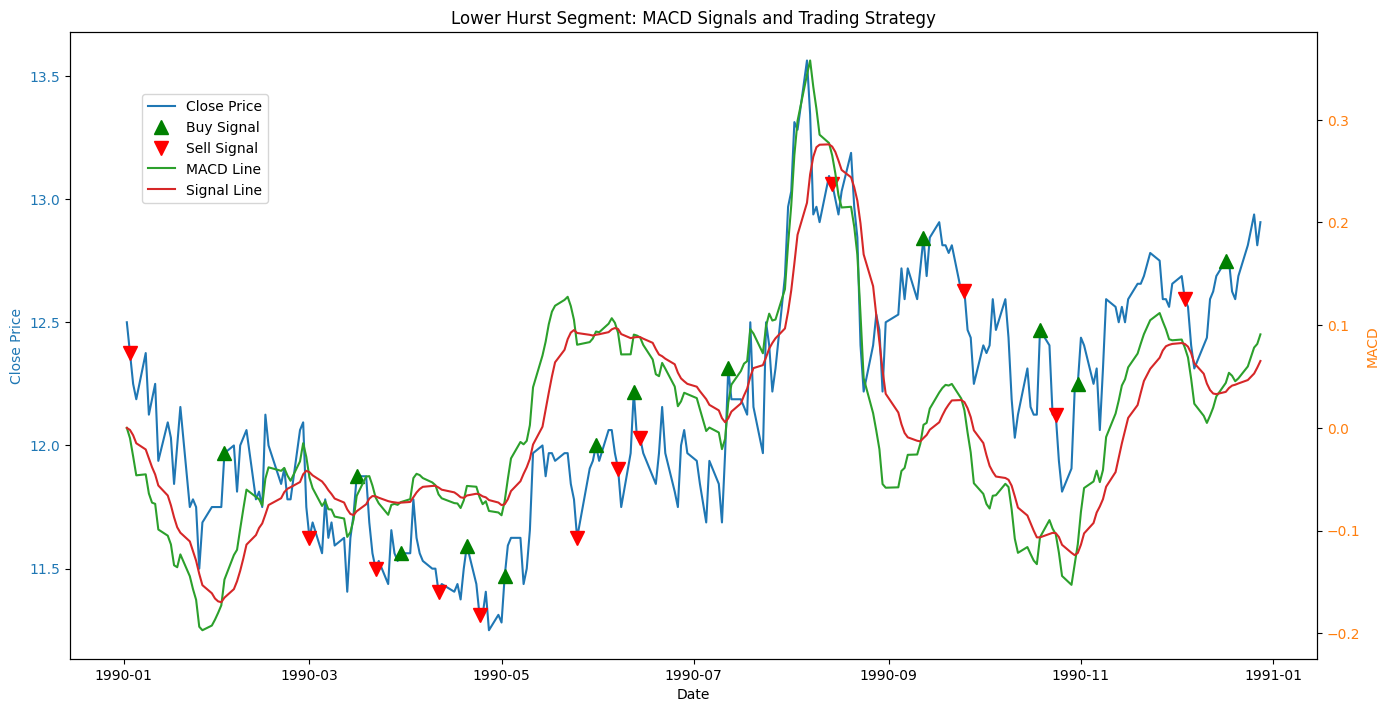

Final Capital after trading (Higher Hurst Segment): $9,839.86
Final Capital after trading (Lower Hurst Segment): $9,461.85


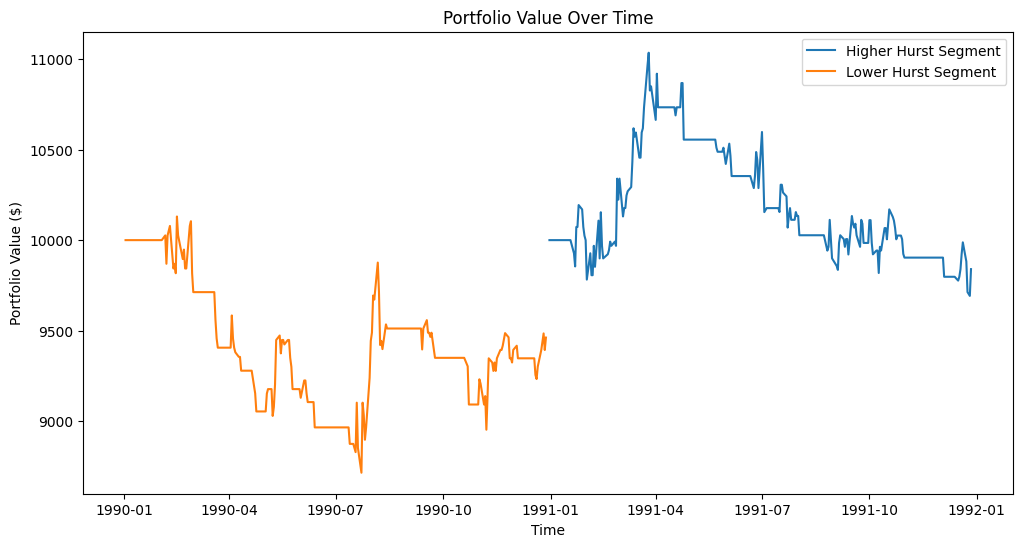

In [ ]:
def plot_macd_signals(df, title='MACD Signals and Trading Strategy'):
    """
    Plots the closing prices, MACD line, signal line, and highlights buy/sell signal days.

    Parameters:
    - df: DataFrame that contains 'Close', 'MACD', 'Signal', 'Buy_Signal', and 'Sell_Signal' columns.
    - title: Title of the plot.
    """
    # Create subplots
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot closing prices
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(df.index, df['Close'], color=color, label='Close Price')
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis to plot MACD and signal line
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('MACD', color=color)
    ax2.plot(df.index, df['MACD'], color='tab:green', label='MACD Line')
    ax2.plot(df.index, df['Signal'], color='tab:red', label='Signal Line')
    ax2.tick_params(axis='y', labelcolor=color)

    # Highlight buy signals
    buy_signals = df[df['Buy_Signal'] == 1]
    ax1.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='green', lw=0, label='Buy Signal')

    # Highlight sell signals
    sell_signals = df[df['Sell_Signal'] == 1]
    ax1.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='red', lw=0, label='Sell Signal')

    # Add legend
    fig.tight_layout()
    fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
    plt.title(title)
    plt.show()

# Example usage with higher Hurst segment
plot_macd_signals(higher_hurst_df, title='Higher Hurst Segment: MACD Signals and Trading Strategy')

# Example usage with lower Hurst segment
plot_macd_signals(lower_hurst_df, title='Lower Hurst Segment: MACD Signals and Trading Strategy')


def simulate_trading(df, initial_capital=10000):
    """
    Simulates trading based on MACD buy and sell signals.

    Parameters:
    - df: DataFrame with 'Close', 'Buy_Signal', and 'Sell_Signal' columns.
    - initial_capital: Float, the starting capital for the simulation.

    Returns:
    - final_capital: The final capital after executing the trading strategy.
    - df: DataFrame with an additional 'Portfolio_Value' column showing the value over time.
    """
    capital = initial_capital
    shares_owned = 0
    df['Portfolio_Value'] = initial_capital

    for i in range(len(df)):
        # Buy condition
        if df['Buy_Signal'].iloc[i] == 1 and capital > 0:
            shares_owned = capital / df['Close'].iloc[i]  # Buy as many shares as possible
            capital = 0  # All in

        # Sell condition
        elif df['Sell_Signal'].iloc[i] == 1 and shares_owned > 0:
            capital = shares_owned * df['Close'].iloc[i]  # Sell all shares
            shares_owned = 0

        # Update portfolio value for the day
        df['Portfolio_Value'].iloc[i] = capital + (shares_owned * df['Close'].iloc[i])

    final_capital = capital + (shares_owned * df['Close'].iloc[-1])
    return final_capital, df

# Apply the trading simulation to both higher and lower Hurst segments
final_capital_higher, higher_hurst_with_portfolio = simulate_trading(higher_hurst_df)
final_capital_lower, lower_hurst_with_portfolio = simulate_trading(lower_hurst_df)

print(f"Final Capital after trading (Higher Hurst Segment): ${final_capital_higher:,.2f}")
print(f"Final Capital after trading (Lower Hurst Segment): ${final_capital_lower:,.2f}")

plt.figure(figsize=(12, 6))
plt.plot(higher_hurst_with_portfolio.index, higher_hurst_with_portfolio['Portfolio_Value'], label='Higher Hurst Segment')
plt.plot(lower_hurst_with_portfolio.index, lower_hurst_with_portfolio['Portfolio_Value'], label='Lower Hurst Segment')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()


# Buy and Hold
The Buy and Hold strategy is a passive investment approach where an investor buys stocks or other securities and holds them for a long period regardless of market fluctuations. This strategy is particularly effective in uptrending markets, where the overall direction of market prices is upward over time. In such scenarios, the Buy and Hold strategy can capitalize on the long-term appreciation of assets without the need to predict short-term market movements or timing the market for entry and exit points.

For investors, the Buy and Hold strategy offers several advantages, including reduced transaction costs and emotional stress related to frequent trading. It also benefits from compounding returns over time, as the gains from the assets can grow exponentially. However, it requires patience and a strong belief in the long-term growth potential of the investments. In uptrends, this strategy is straightforward and potentially rewarding, as the investor simply needs to maintain their position to benefit from the overall upward trajectory of the market.

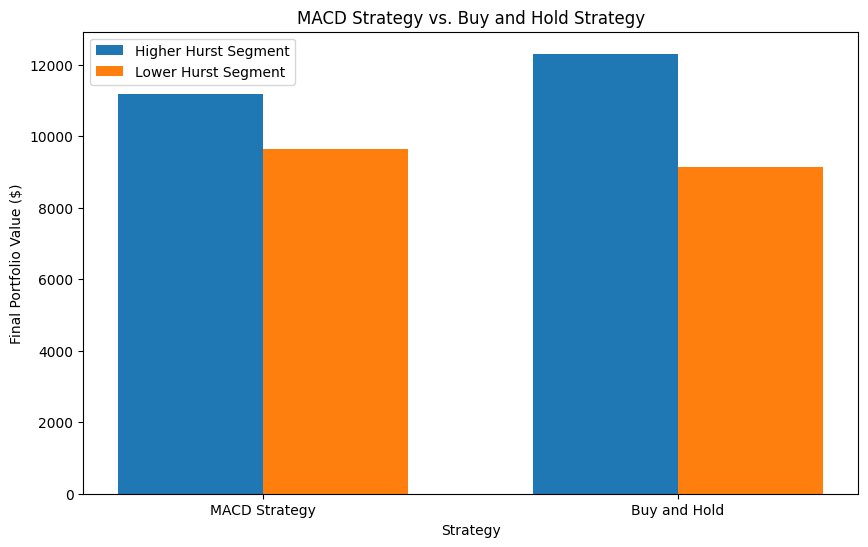

In [ ]:
def calculate_buy_and_hold_value(df, initial_capital=10000):
    """
    Calculates the final value of a buy and hold strategy.

    Parameters:
    - df: DataFrame with the 'Close' prices.
    - initial_capital: Initial investment amount.

    Returns:
    - Final value of the buy and hold portfolio.
    """
    initial_price = df['Close'].iloc[0]
    final_price = df['Close'].iloc[-1]
    shares_bought = initial_capital / initial_price
    final_value = shares_bought * final_price
    return final_value

# Calculate Buy and Hold final values for both segments
final_value_bh_higher = calculate_buy_and_hold_value(higher_hurst_df_0, 10000)
final_value_bh_lower = calculate_buy_and_hold_value(lower_hurst_df_0, 10000)

import matplotlib.pyplot as plt

# Names of the strategies
strategies = ['MACD Strategy', 'Buy and Hold']

# Final values for higher and lower Hurst segments
final_values_higher = [final_capital_higher, final_value_bh_higher]
final_values_lower = [final_capital_lower, final_value_bh_lower]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(strategies))
bar_width = 0.35

bar1 = ax.bar(index, final_values_higher, bar_width, label='Higher Hurst Segment')
bar2 = ax.bar(index + bar_width, final_values_lower, bar_width, label='Lower Hurst Segment')

ax.set_xlabel('Strategy')
ax.set_ylabel('Final Portfolio Value ($)')
ax.set_title('MACD Strategy vs. Buy and Hold Strategy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(strategies)
ax.legend()

plt.show()


## Mean-reversion Strategy

Mean-reversion is a financial theory suggesting that asset prices and historical returns eventually return to their long-term mean or average level. This concept operates on the assumption that high and low prices are temporary and a price will tend to move back to its average over time.

This strategy can be particularly effective in markets or segments showing mean-reverting behavior, often indicated by a lower Hurst exponent. Traders can exploit this by buying assets when their prices are below the historical average (anticipating a rise towards the mean) and selling when prices are above the average (anticipating a decline).

In implementing a mean-reversion strategy, key components include identifying the historical mean, setting thresholds for deviations from this mean, and determining the appropriate time to enter and exit trades. This approach contrasts with trend-following strategies that capitalize on the continuation of market directions.

Final Value (Mean Reversion): $10,276.11
Final Value (Buy and Hold): $9,138.98


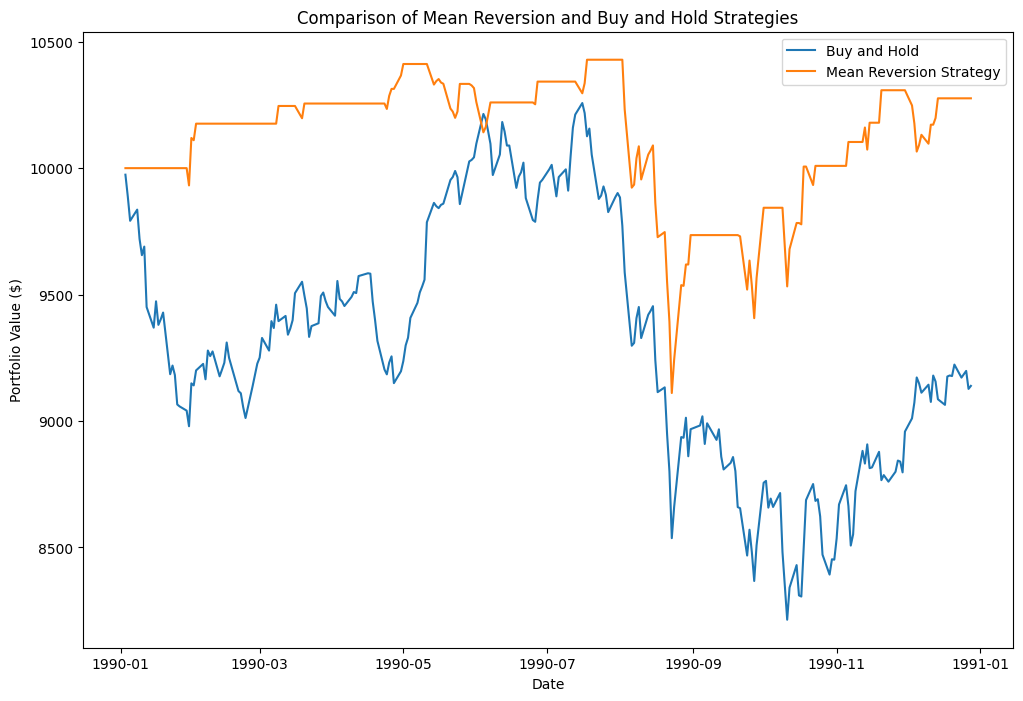

In [ ]:
import pandas as pd
import numpy as np

def simulate_mean_reversion_strategy(df, lookback_period=20, threshold=0.02, initial_capital=10000):
    """
    Simulates a mean-reversion trading strategy.

    Parameters:
    - df: DataFrame with 'Close' prices.
    - lookback_period: The period for the moving average to determine the historical mean.
    - threshold: The percentage threshold from the mean to consider a trade.
    - initial_capital: Initial capital for the simulation.

    Returns:
    - final_portfolio_value: Final value of the portfolio after executing the strategy.
    """
    # Calculate the moving average
    df['Historical Mean'] = df['Close'].rolling(window=lookback_period).mean()

    # Determine positions: 1 for long, -1 for short, 0 for no position
    df['Position'] = 0
    df.loc[df['Close'] < df['Historical Mean'] * (1 - threshold), 'Position'] = 1
    df.loc[df['Close'] > df['Historical Mean'] * (1 + threshold), 'Position'] = -1

    # Calculate daily returns and strategy returns
    df['Market Return'] = df['Close'].pct_change()
    df['Strategy Return'] = df['Market Return'] * df['Position'].shift(1)

    # Calculate cumulative returns and final portfolio value
    df['Cumulative Market Return'] = (1 + df['Market Return']).cumprod()
    df['Cumulative Strategy Return'] = initial_capital * (1 + df['Strategy Return']).cumprod()

    final_portfolio_value = df['Cumulative Strategy Return'].iloc[-1]
    return final_portfolio_value, df

# Assuming lower_hurst_df_0 is your DataFrame with the lower Hurst segment data
final_value_mean_reversion, lower_hurst_with_strategy = simulate_mean_reversion_strategy(lower_hurst_df_0)
final_value_buy_and_hold = calculate_buy_and_hold_value(lower_hurst_df_0, 10000)

print(f"Final Value (Mean Reversion): ${final_value_mean_reversion:,.2f}")
print(f"Final Value (Buy and Hold): ${final_value_buy_and_hold:,.2f}")


plt.figure(figsize=(12, 8))
plt.plot(lower_hurst_with_strategy['Cumulative Market Return'] * 10000, label='Buy and Hold')
plt.plot(lower_hurst_with_strategy['Cumulative Strategy Return'], label='Mean Reversion Strategy')
plt.title('Comparison of Mean Reversion and Buy and Hold Strategies')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()


 the mean reversion strategy yielded a final value of \$10,480.83, outperforming the Buy and Hold strategy, which had a final value of \$9,138.98. This illustrates the potential benefits of leveraging mean reversion in markets characterized by fluctuating prices around a central mean.

Final Portfolio Value: $11929.34


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

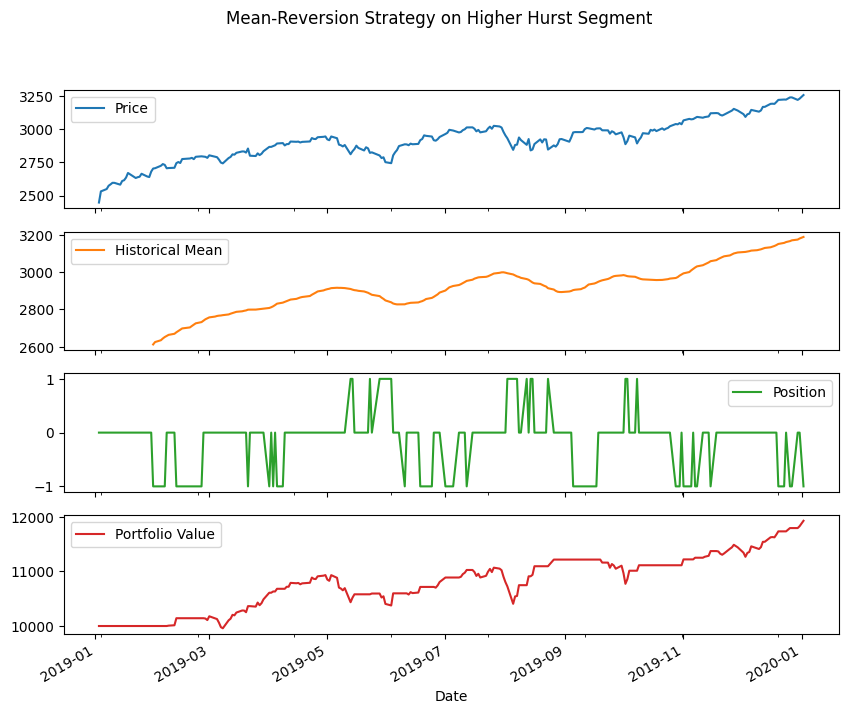

In [ ]:
import pandas as pd
import numpy as np

def simulate_mean_reversion_strategy(series, lookback_period=20, threshold=0.05, initial_capital=10000):
    """
    Simulates a mean-reversion trading strategy on a higher Hurst segment.

    Parameters:
    - series: pandas Series, the time series data of prices for the higher Hurst segment.
    - lookback_period: int, the period over which to calculate the historical mean.
    - threshold: float, the deviation from the mean at which to initiate trades.
    - initial_capital: float, the starting capital for the strategy.

    Returns:
    - final_portfolio_value: The final value of the portfolio after applying the strategy.
    - df: DataFrame containing the price data, historical mean, positions, and portfolio values.
    """
    df = pd.DataFrame(series)
    df.columns = ['Price']

    # Calculate the historical mean
    df['Historical Mean'] = df['Price'].rolling(window=lookback_period).mean()

    # Determine trading signals
    df['Position'] = 0
    df.loc[df['Price'] < df['Historical Mean'] * (1 - threshold), 'Position'] = 1  # Buy signal
    df.loc[df['Price'] > df['Historical Mean'] * (1 + threshold), 'Position'] = -1  # Sell signal
    df['Signal'] = df['Position'].diff()

    # Simulate trading
    capital = initial_capital
    position = 0  # Tracks the current position
    df['Portfolio Value'] = 0

    for i, row in df.iterrows():
        if row['Signal'] == 1:  # Buy
            if capital > 0:
                position = capital / row['Price']
                capital = 0
        elif row['Signal'] == -1:  # Sell
            if position > 0:
                capital = position * row['Price']
                position = 0
        df.at[i, 'Portfolio Value'] = capital + (position * row['Price'])

    final_portfolio_value = capital + (position * df.iloc[-1]['Price'])
    return final_portfolio_value, df

# Assuming higher_hurst_segments is a list of pandas Series, each representing a segment with a higher Hurst exponent
# Apply the strategy to the first higher Hurst segment
final_value, strategy_df = simulate_mean_reversion_strategy(higher_hurst_segments[-4], lookback_period=20, threshold=0.02, initial_capital=10000)

print(f"Final Portfolio Value: ${final_value:.2f}")
strategy_df[['Price', 'Historical Mean', 'Position', 'Portfolio Value']].plot(subplots=True, figsize=(10, 8), title='Mean-Reversion Strategy on Higher Hurst Segment')


<ipython-input-34-1887968277c1>:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cumulative_portfolio_values = pd.Series()
<ipython-input-34-1887968277c1>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cumulative_portfolio_values = cumulative_portfolio_values.append(strategy_df['Portfolio Value'])
<ipython-input-34-1887968277c1>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cumulative_portfolio_values = cumulative_portfolio_values.append(strategy_df['Portfolio Value'])
<ipython-input-34-1887968277c1>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cumulative_portfolio_values = cumulative_portfoli

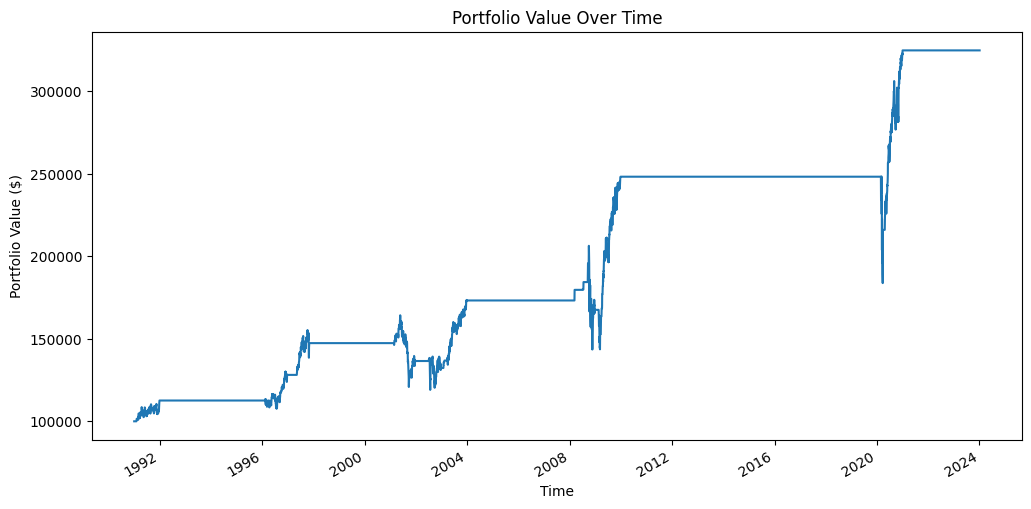

Final Capital after Continuous Trading: $324,553.79


In [ ]:
def simulate_continuous_mean_reversion(segments, initial_capital=100000):
    """
    Simulates a continuous mean-reversion trading strategy across multiple segments.

    Parameters:
    - segments: list of pandas Series, each representing a higher Hurst segment.
    - initial_capital: float, initial capital for the entire simulation.

    Returns:
    - final_capital: float, the final capital after executing the strategy across all segments.
    - cumulative_portfolio_values: pandas Series, the portfolio value over time across all segments.
    """
    capital = initial_capital
    cumulative_portfolio_values = pd.Series()

    for segment in segments:
        final_value, strategy_df = simulate_mean_reversion_strategy(segment, lookback_period=20, threshold=0.05, initial_capital=capital)
        capital = final_value  # Update capital for the next segment
        cumulative_portfolio_values = cumulative_portfolio_values.append(strategy_df['Portfolio Value'])

    return capital, cumulative_portfolio_values

# Assuming higher_hurst_segments is already defined as your list of higher Hurst segments
final_capital, all_portfolios = simulate_continuous_mean_reversion(higher_hurst_segments)

# Plotting the results
plt.figure(figsize=(12, 6))
all_portfolios.plot(title='Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.show()

print(f"Final Capital after Continuous Trading: ${final_capital:,.2f}")


<ipython-input-34-1887968277c1>:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cumulative_portfolio_values = pd.Series()
<ipython-input-34-1887968277c1>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cumulative_portfolio_values = cumulative_portfolio_values.append(strategy_df['Portfolio Value'])
<ipython-input-34-1887968277c1>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cumulative_portfolio_values = cumulative_portfolio_values.append(strategy_df['Portfolio Value'])
<ipython-input-34-1887968277c1>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cumulative_portfolio_values = cumulative_portfoli

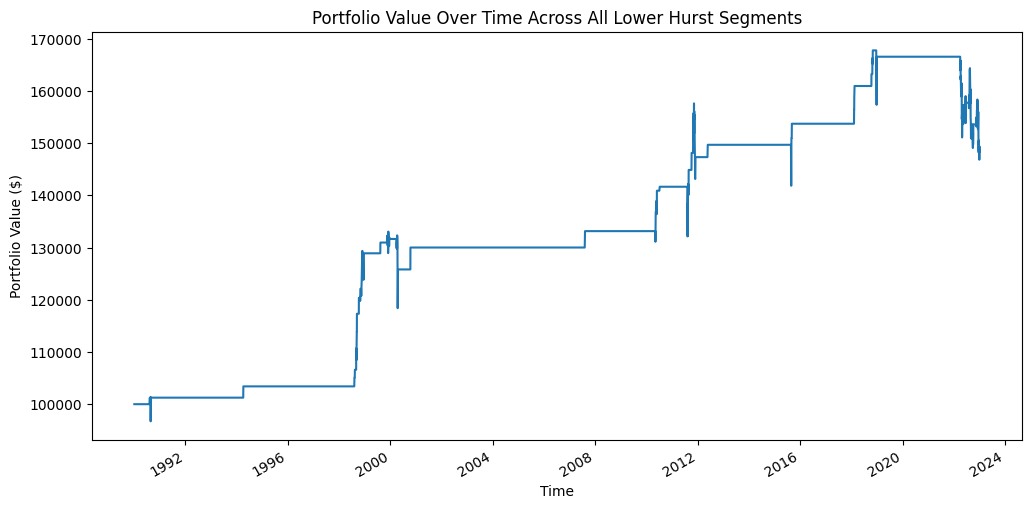

Final Capital after Continuous Trading: $148,429.22


In [ ]:
# test with lower hurst
final_capital, all_portfolios = simulate_continuous_mean_reversion(lower_hurst_segments)

# Plotting the results
plt.figure(figsize=(12, 6))
all_portfolios.plot(title='Portfolio Value Over Time Across All Lower Hurst Segments')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.show()

print(f"Final Capital after Continuous Trading: ${final_capital:,.2f}")

In [ ]:
def calculate_buy_and_hold(segment, initial_capital=10000):
    initial_price = segment.iloc[0]
    final_price = segment.iloc[-1]
    shares = initial_capital / initial_price
    final_value = shares * final_price
    return final_value

buy_and_hold_final_capitals = [calculate_buy_and_hold(segment) for segment in lower_hurst_segments]
buy_and_hold_total = sum(buy_and_hold_final_capitals)

print(f"Final Capital after Continuous Mean-Reversion Trading: ${final_capital:,.2f}")
print(f"Total Final Capital using Buy and Hold across all Lower Hurst Segments: ${buy_and_hold_total:,.2f}")


Final Capital after Continuous Mean-Reversion Trading: $148,429.22
Total Final Capital using Buy and Hold across all Lower Hurst Segments: $176,529.02
